# Instacart Market Basket Analysis 

by Hyder Ali

## Part 1: Interactive Data Exploration & Analysis

The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. The goal is then to predict which previously purchased products will be in a user's next order. Now let's jump straight into the data and do some exploratory analysis.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
order_products_train = pd.read_csv('data/order_products__train.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')

Firstly, let's explore __order.products.train__ and __order.products.prior__ files. These files specify which products were purchased in each order. More specifically, __order.products.prior__ contains previous order contents for all customers and __order.products.train__ contains the last orders for some customers only.

In [4]:
print("The order_products_train size is: ", order_products_train.shape)
print("The order_products_prior size is: ", order_products_prior.shape)

The order_products_train size is:  (1384617, 4)
The order_products_prior size is:  (32434489, 4)


In [5]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Now, let's concatenate them in the same order.products dataframe

In [7]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis = 0)
print("The oder_products_all size is : ", order_products_all.shape)

The oder_products_all size is :  (33819106, 4)


In [8]:
order_products_all.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
orders_unique = len(set(order_products_all.order_id))
products_unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" % (orders_unique, products_unique))

There are 3346083 orders for 49685 products


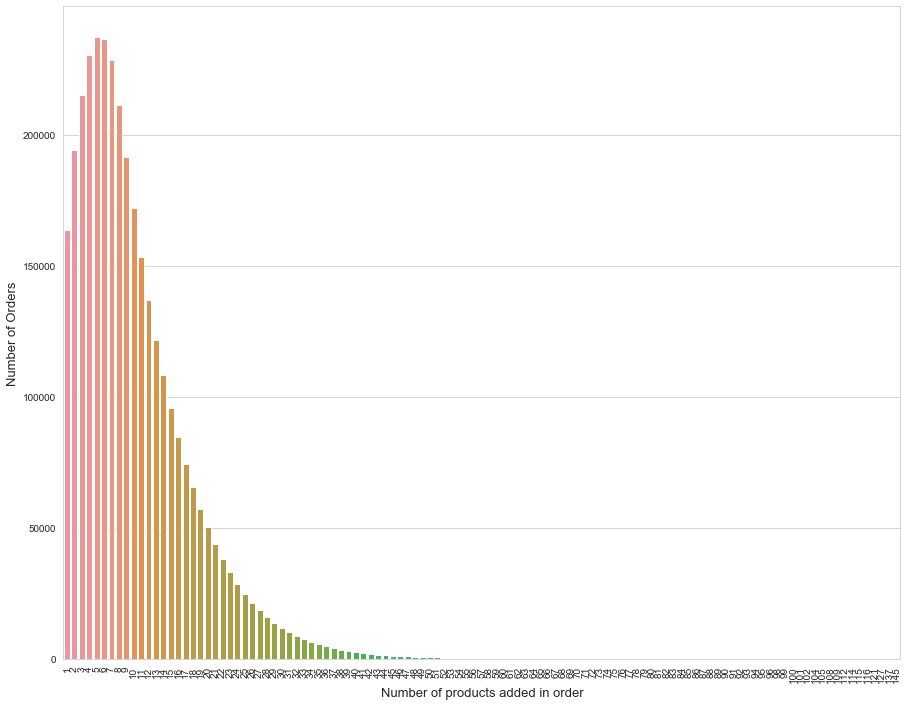

In [10]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

We can observe that people usually order around 5 products.

In [11]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'count'}).reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
grouped

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


Fruits like Banana, Strawberries, Organic ... are the most ordered products.

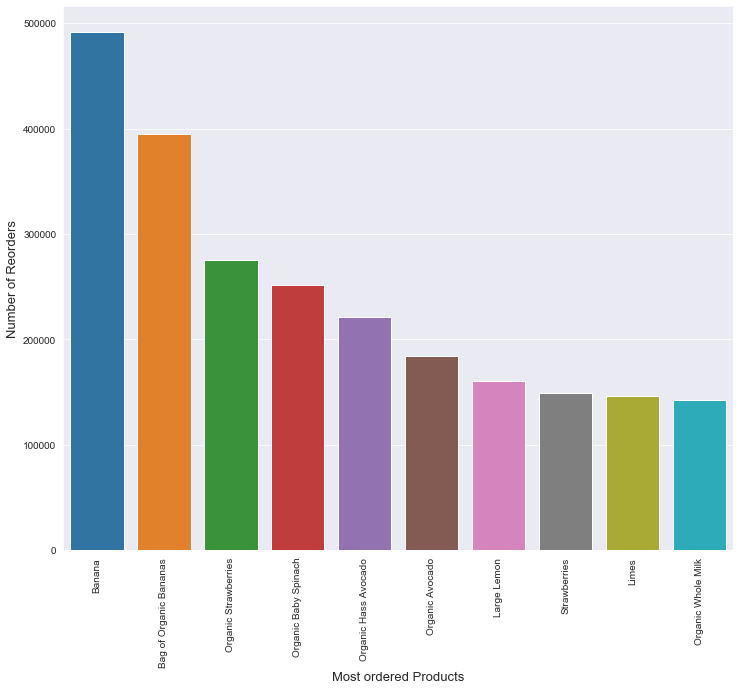

In [12]:
grouped  = grouped.groupby(['product_name']).sum()['Total_reorders'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

Do people usually reorder the same previous ordered products?

In [13]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

,reordered,Total_products,Ratios
0,0,13863746,0.410
1,1,19955360,0.590


__59%__ of ordered products are previosuly ordered by customers.

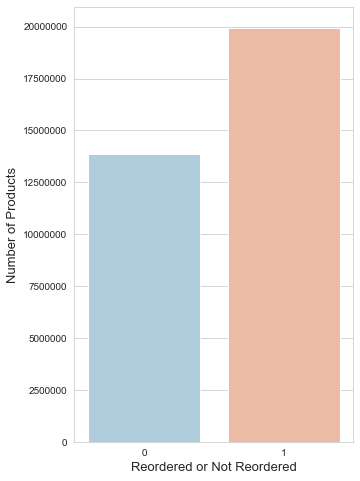

In [14]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Which products are usually reordered?

In [15]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.reorder_total > 75].sort_values(['reorder_probability'], ascending=False)[:10]
grouped

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.922,Chocolate Love Bar
35601,35604,93,104,0.894,Maca Buttercups
38248,38251,99,111,0.892,Benchbreak Chardonnay
36798,36801,88,99,0.889,Organic Blueberry B Mega
10233,10236,114,131,0.870,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868,Thousand Island Salad Snax
5455,5457,78,90,0.867,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861,Half And Half Ultra Pasteurized


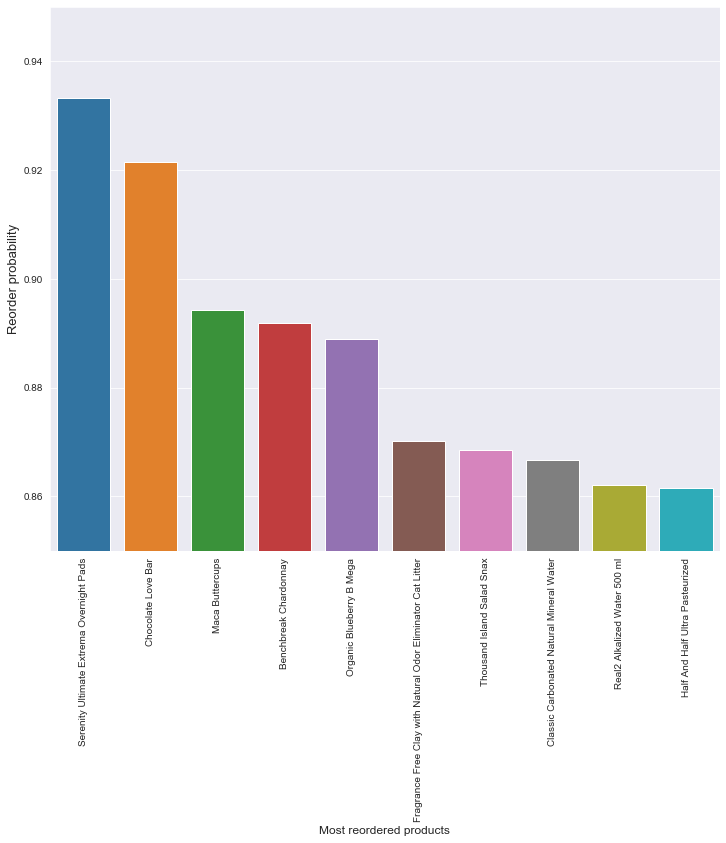

In [16]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylim([0.85,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.show()

Let's explore the __orders__ file.

In [17]:
print("The orders data size is : ", orders.shape)
print("Columns in orders data are: ", orders.columns.values)

The orders data size is :  (3421083, 7)
Columns in orders data are:  ['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [18]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,nan
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000


In [19]:
orders_na = (orders.isnull().sum() / len(orders)) * 100
orders_na = orders_na.drop(orders_na[orders_na == 0].index).sort_values(ascending=False)
orders_na

days_since_prior_order   6.028
dtype: float64

__days.since.prior.order__ has 6.028% missing values.

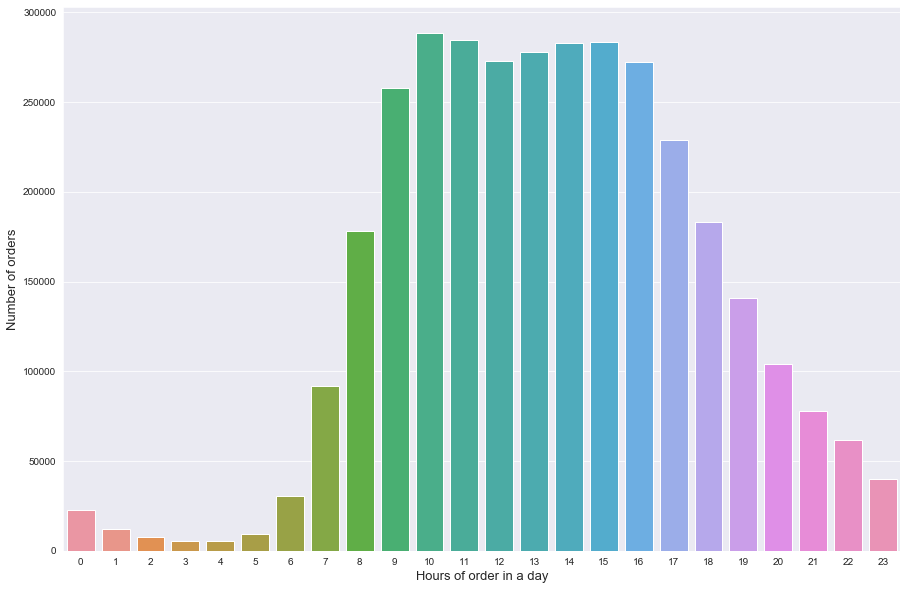

In [20]:
grouped = orders.groupby("order_id")["order_hour_of_day"].aggregate("sum").reset_index()
grouped = grouped.order_hour_of_day.value_counts()

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Hours of order in a day', fontsize=13)
plt.show()

People mostly order between 8 and 19-th hour, between 8 am to 7 pm.

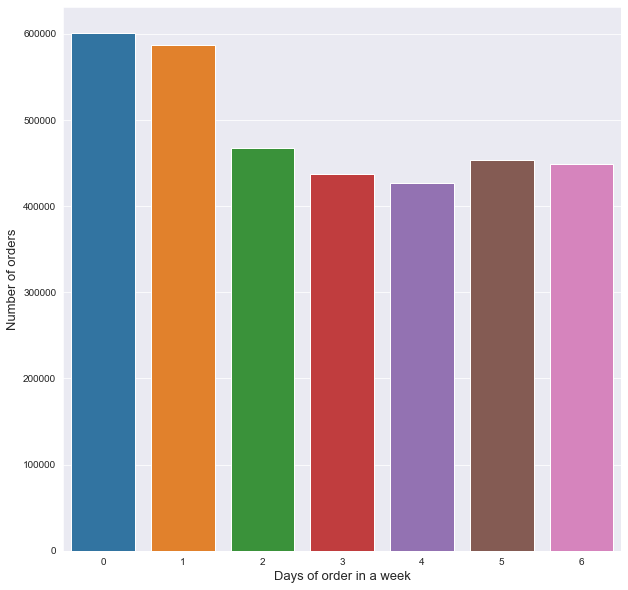

In [21]:
grouped = orders.groupby("order_id")["order_dow"].aggregate("sum").reset_index()
grouped = grouped.order_dow.value_counts()

f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Days of order in a week', fontsize=13)
plt.show()

People usually order at days 0 to 2 (anonimyzed days corresponding to the weekend).

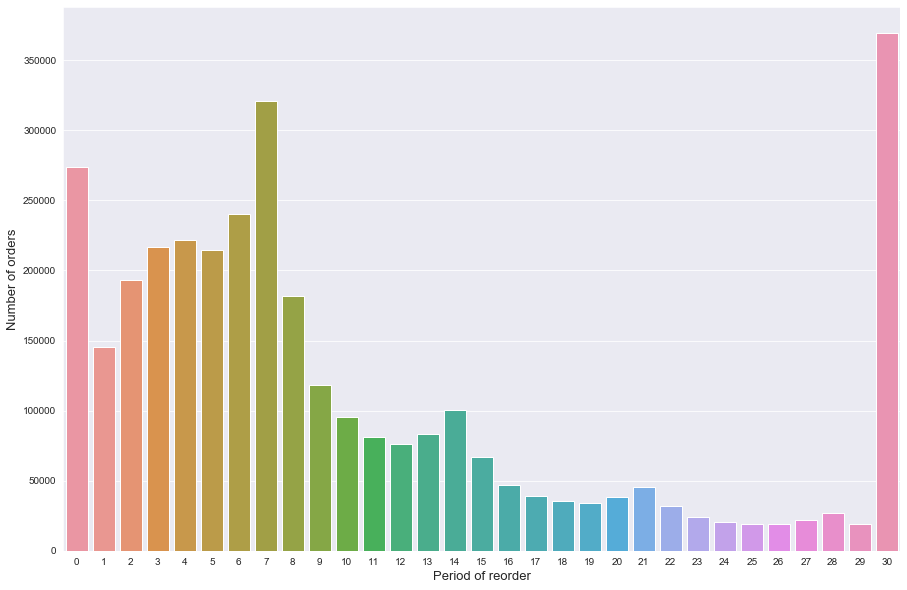

In [22]:
grouped = orders.groupby("order_id")["days_since_prior_order"].aggregate("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(grouped.index, grouped.values)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

People usually reorder either after 1 week or after 1 month.

Number and ratio of orders from the three datasets (prior, train, test).

In [23]:
grouped = orders.groupby("eval_set")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped

,eval_set,Total_orders,Ratio
0,prior,3214874,0.940
1,test,75000,0.022
2,train,131209,0.038


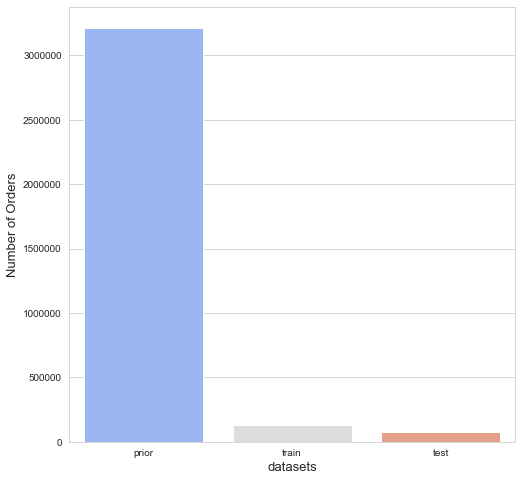

In [24]:
grouped  = grouped.groupby(['eval_set']).sum()['Total_orders'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('datasets', fontsize=13)
plt.show()

Let's check the number of orders made by each costumer in the whole dataset.

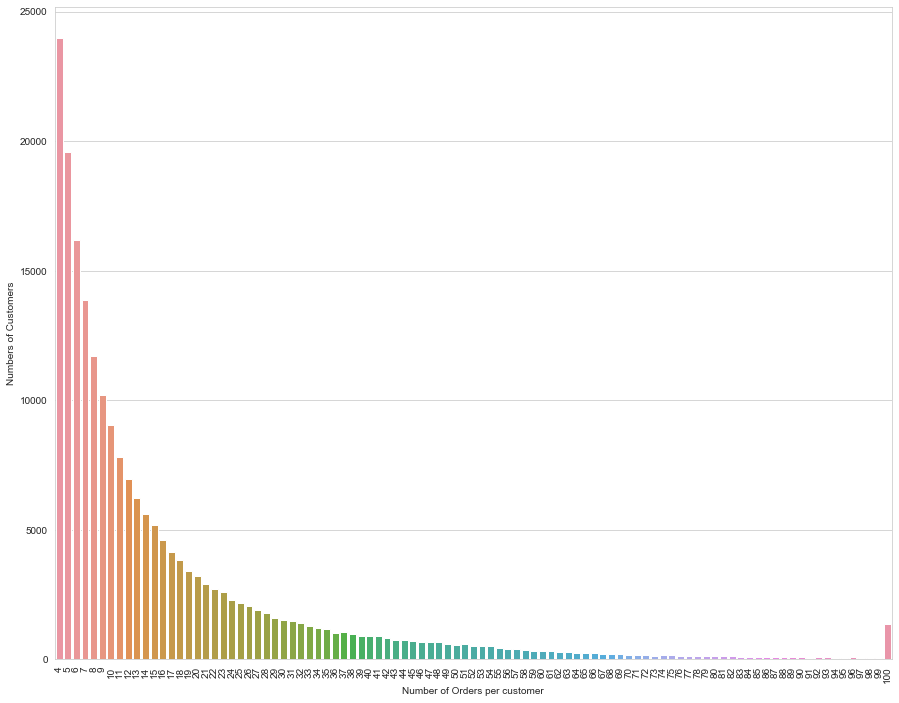

In [25]:
grouped = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate("count")

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(grouped.index, grouped.user_id)
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

We can observe that most customers made 4 orders. Now let's explore the items datasets (products, departments and aisles files).

In [26]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [27]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [28]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [29]:
items = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [30]:
grouped = items.groupby("department")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped

,department,Total_products,Ratio
17,personal care,6563,0.132
20,snacks,6264,0.126
16,pantry,5371,0.108
3,beverages,4365,0.088
10,frozen,4007,0.081
7,dairy eggs,3449,0.069
11,household,3085,0.062
6,canned goods,2092,0.042
9,dry goods pasta,1858,0.037
19,produce,1684,0.034


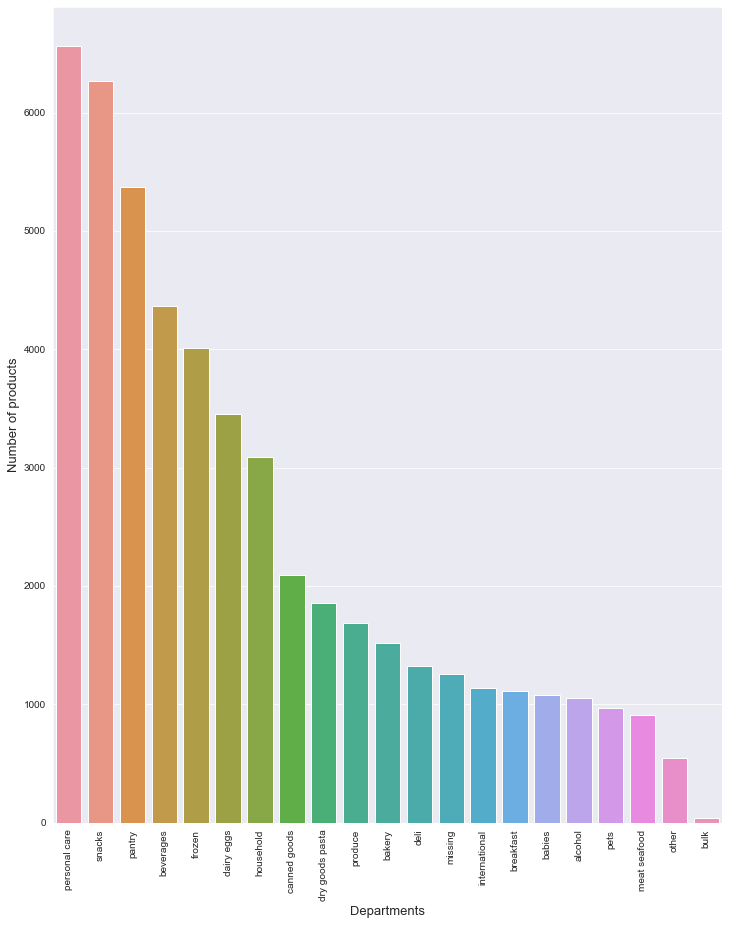

In [31]:
grouped = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

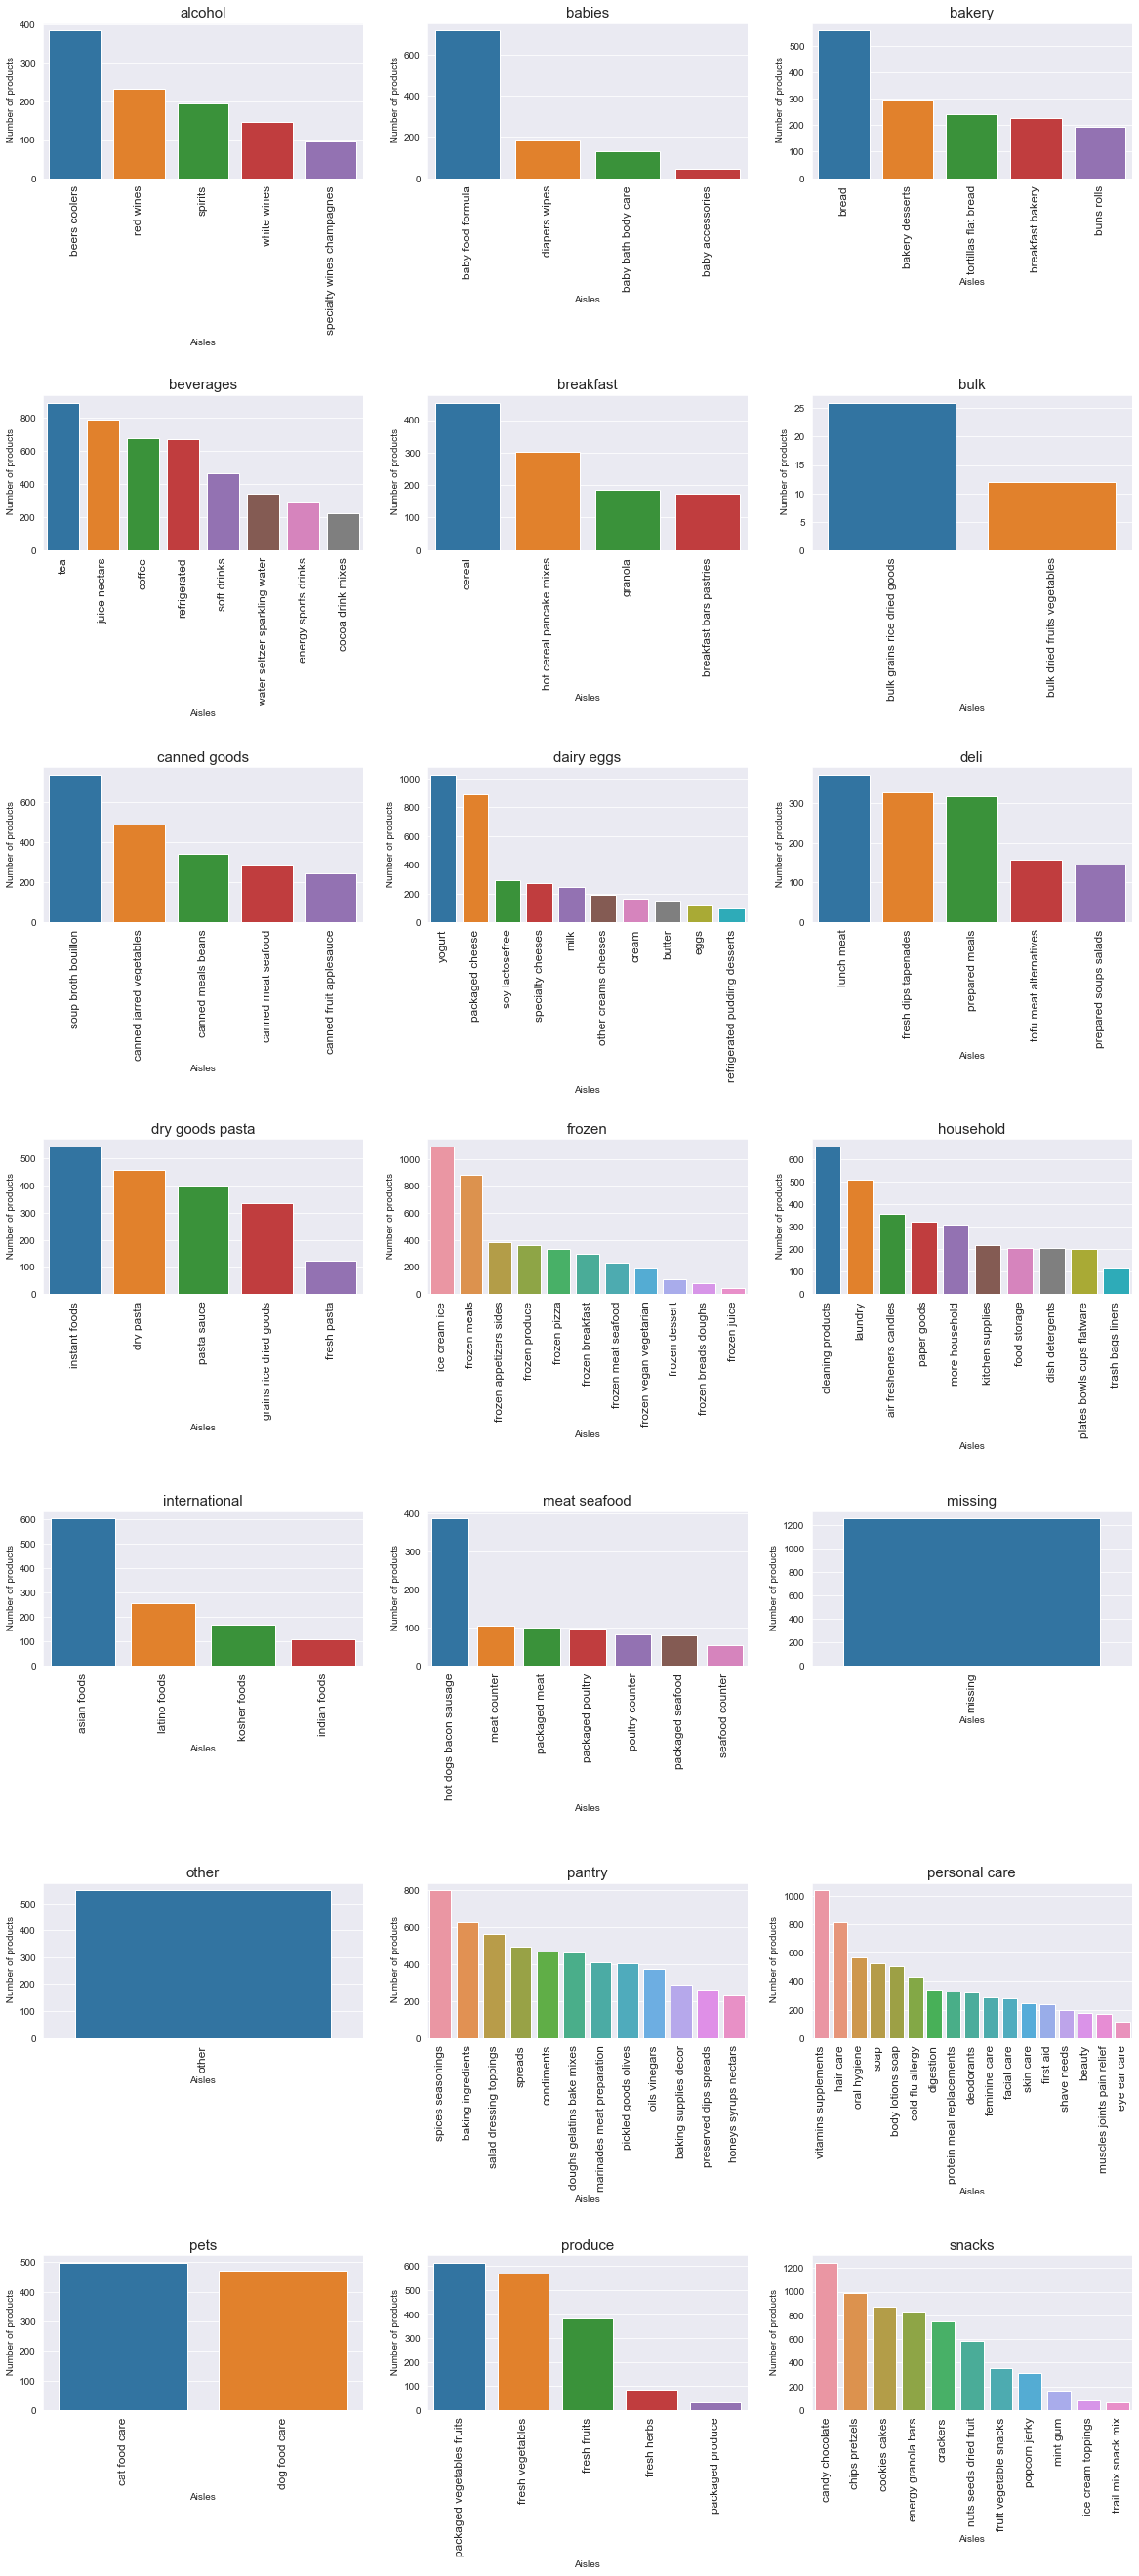

In [32]:
grouped = items.groupby(["department", "aisle"])["product_id"].aggregate({'Total_products': 'count'}).reset_index()

grouped.sort_values(by='Total_products', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))

for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_products , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

In [33]:
grouped = items.groupby("aisle")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

,aisle,Total_products,Ratio
85,missing,1258,0.025
18,candy chocolate,1246,0.025
71,ice cream ice,1091,0.022
130,vitamins supplements,1038,0.021
133,yogurt,1026,0.021
25,chips pretzels,989,0.020
125,tea,894,0.018
93,packaged cheese,891,0.018
59,frozen meals,880,0.018
31,cookies cakes,874,0.018


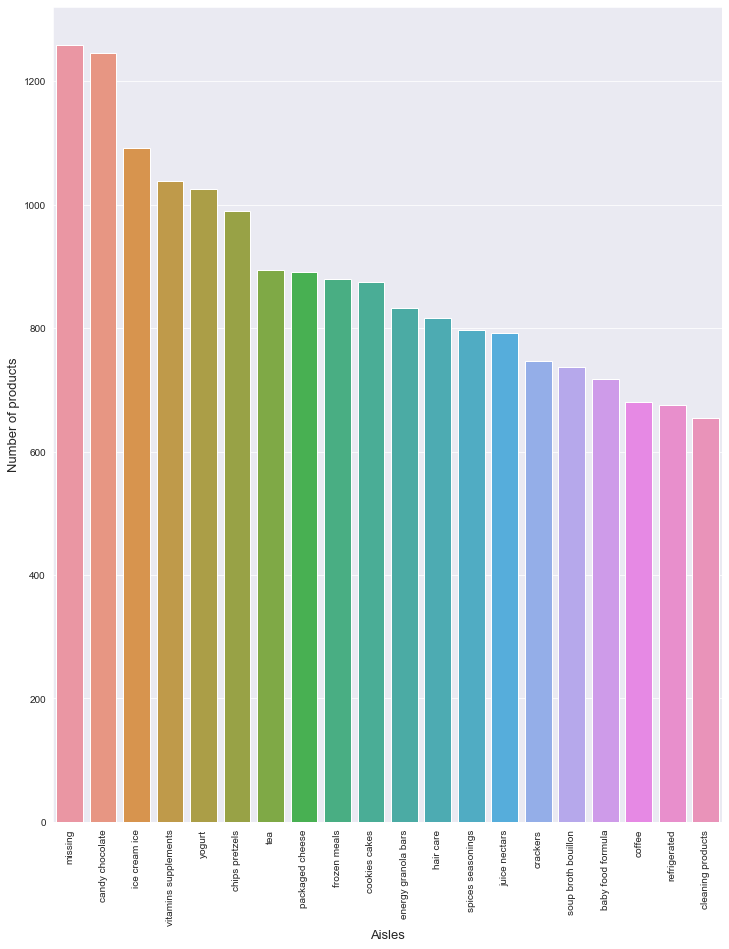

In [34]:
grouped  = grouped.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

In [35]:
users_flow = orders[['user_id', 'order_id']].merge(order_products_train[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')
users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')

In [36]:
grouped = users_flow.groupby("department")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped

,department,Total_orders,Ratio
19,produce,409087,0.295
7,dairy eggs,217051,0.157
20,snacks,118862,0.086
3,beverages,114046,0.082
10,frozen,100426,0.073
16,pantry,81242,0.059
2,bakery,48394,0.035
6,canned goods,46799,0.034
8,deli,44291,0.032
9,dry goods pasta,38713,0.028


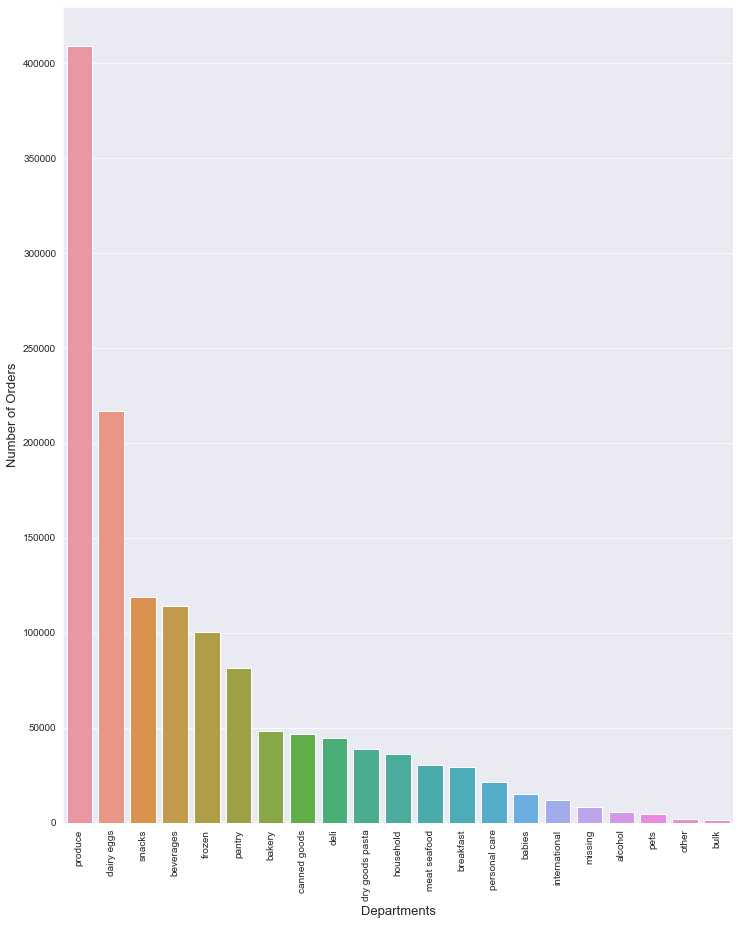

In [37]:
grouped = grouped.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

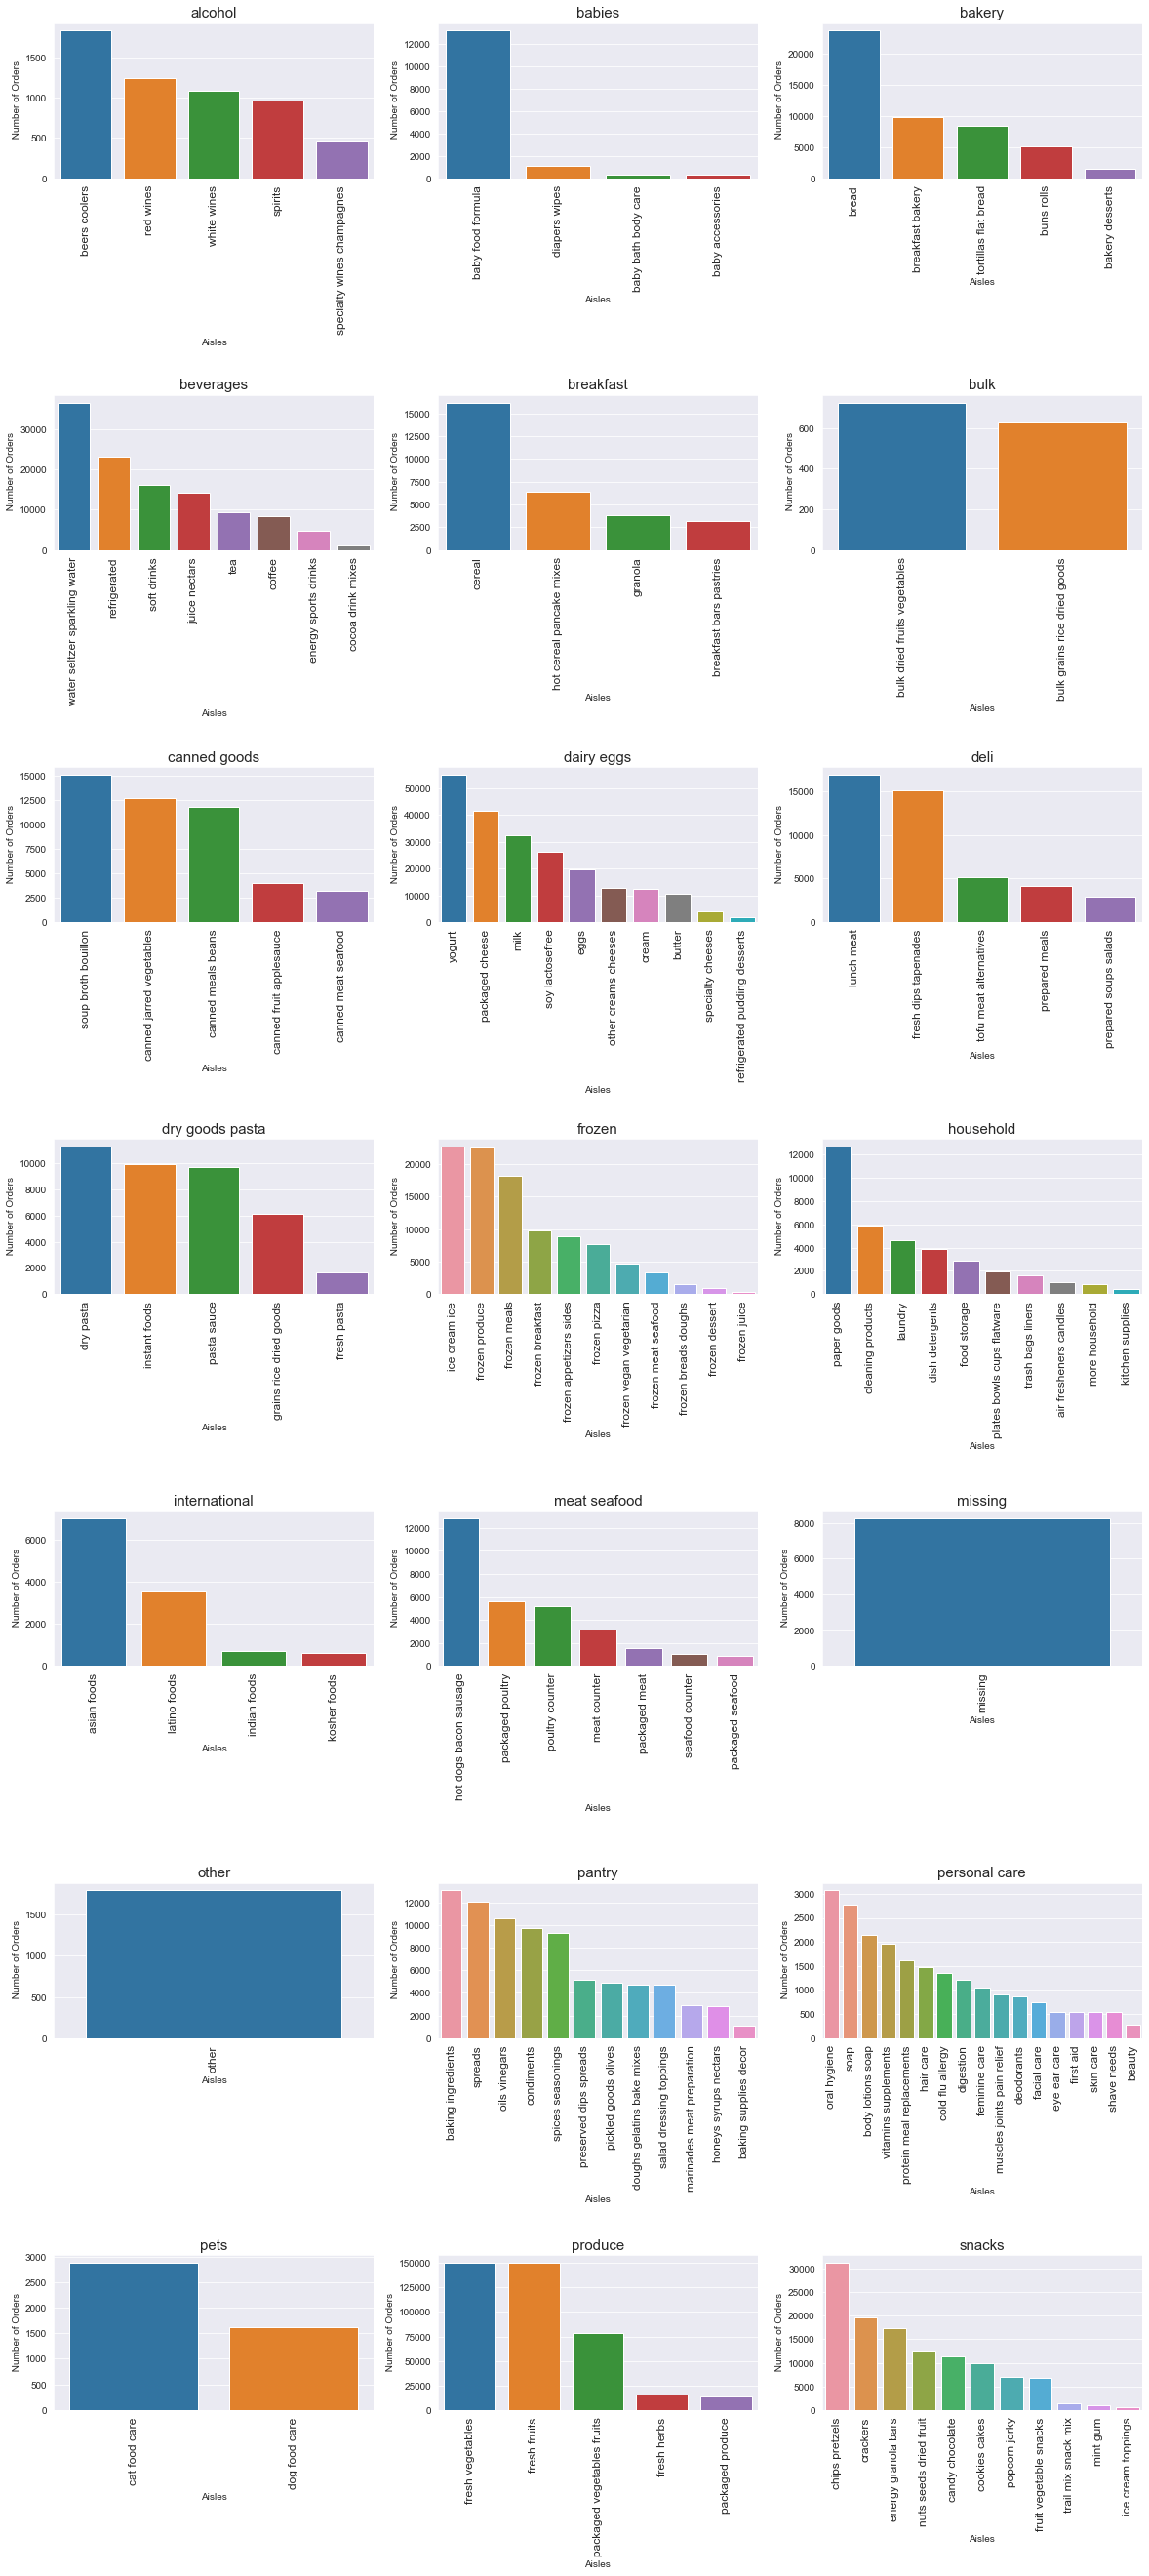

In [38]:
grouped = users_flow.groupby(["department", "aisle"])["order_id"].aggregate({'Total_orders': 'count'}).reset_index()

grouped.sort_values(by='Total_orders', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))

for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(group.aisle, group.Total_orders , ax=ax)
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

In [39]:
grouped = users_flow.groupby("aisle")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True )
grouped.head(10)

,aisle,Total_orders,Ratio
53,fresh vegetables,150609,0.109
50,fresh fruits,150473,0.109
98,packaged vegetables fruits,78493,0.057
133,yogurt,55240,0.040
93,packaged cheese,41699,0.030
131,water seltzer sparkling water,36617,0.026
83,milk,32644,0.024
25,chips pretzels,31269,0.023
119,soy lactosefree,26240,0.019
11,bread,23635,0.017


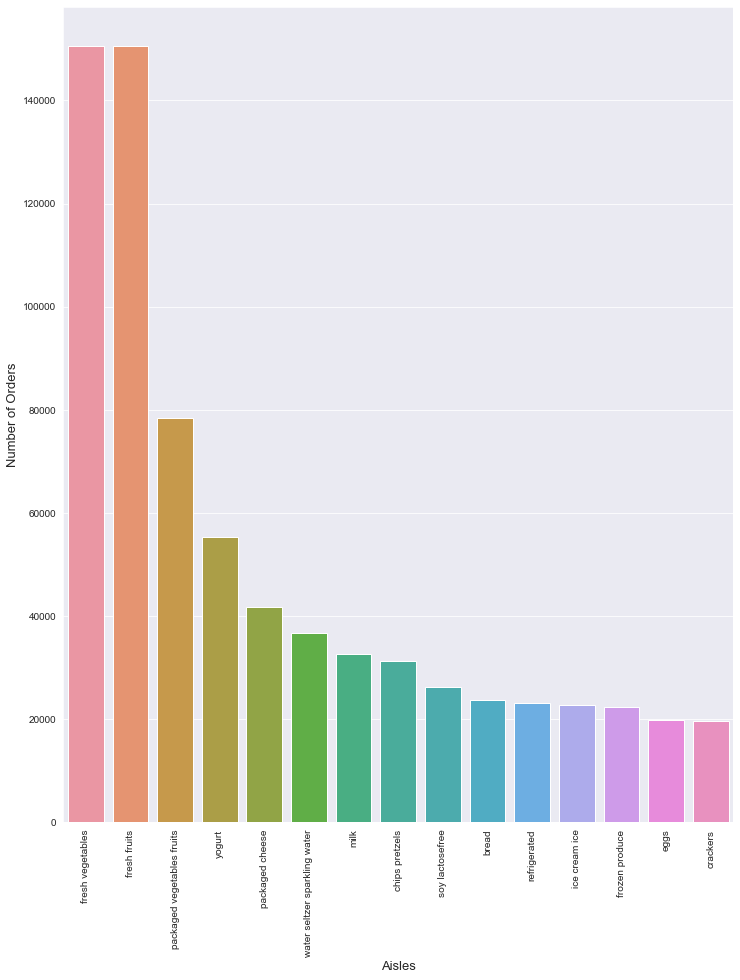

In [40]:
grouped = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]

f, ax = plt.subplots(figsize=(12, 15))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

## Part 2: Customer Segmentation with PCA

In [41]:
orders = pd.read_csv('data/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,nan
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000


In [42]:
prior = pd.read_csv('data/order_products__prior.csv')
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [43]:
train = pd.read_csv('data/order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


- Users are identified by user.id in the orders.csv file. Each row of the orders.csv file represents an order made by a user. Order are identified by order_id.
- Each order of a user is characterized by an order_number which specifies when it has been made with respect to the others of the same user.
- Each order consists of a set of product each characterized by an add_to_cart_order feature representing the sequence in which they have been added to the cart in that order.
- For each user we may have n - 1 prior orders and 1 train order OR n - 1 prior orders and 1 test order in which we have to state what products have been reordered.

In [44]:
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
4089398,431534,196,1,1,1,prior,5,4,15,28.000
4089399,431534,12427,2,1,1,prior,5,4,15,28.000
4089400,431534,10258,3,1,1,prior,5,4,15,28.000
4089401,431534,25133,4,1,1,prior,5,4,15,28.000
4089402,431534,10326,5,0,1,prior,5,4,15,28.000


In [47]:
products = pd.read_csv('data/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [48]:
aisles = pd.read_csv('data/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [49]:
print(aisles.shape)

(134, 2)


In [50]:
_mt = pd.merge(prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.000,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.000,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.000,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.000,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.000,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.000,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.000,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.000,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.000,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.000,eggs


In [51]:
mt['product_name'].value_counts()[0:10]

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64

In [52]:
len(mt['product_name'].unique())

49677

In [53]:
prior.shape

(32434489, 4)

In [54]:
len(mt['aisle'].unique())

134

We are dealing with 134 types of product (aisle).

In [55]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
Name: aisle, dtype: int64

Fresh fruits and fresh vegetables are the best selling goods.

The ideas here is to find possible clusters among the different customers and substitute single user_id with the cluster to which they are assumed to belong. Hope this would eventually increase the next prediction model performance.

The first thing to do is creating a dataframe with all the purchases made by each user.

In [56]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


In [57]:
cust_prod.shape

(206209, 134)

We proceed to perform a PCA to the dataframe to reduce the number of features from 134 Aisles to 6.

In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [59]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-24.216,2.429,-2.466,-0.146,0.269,-1.433
1,6.463,36.751,8.383,15.098,-6.921,-0.979
2,-7.990,2.404,-11.030,0.672,-0.442,-2.823
3,-27.991,-0.756,-1.922,2.092,-0.288,0.926
4,-19.896,-2.637,0.533,3.679,0.613,-1.624


Each PCA component is representative of the dataset, based on visual inspection have chosen (PC4, PC1) pair for K-Means Clustering.

(206209, 2)
       4      1
0  0.269  2.429
1 -6.921 36.751
2 -0.442  2.404
3 -0.288 -0.756
4  0.613 -2.637


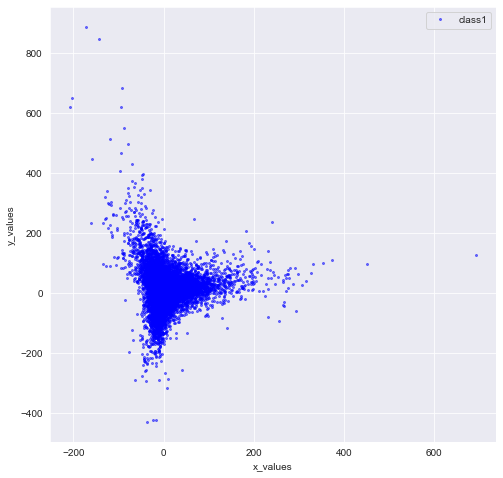

In [60]:
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [61]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ -0.11868823   0.09644088]
 [-11.26759466  65.248165  ]
 [ -4.71388798 -40.63421033]
 [ 76.82338045  26.26358548]]


In [62]:
print (c_preds[0:100])

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 0]


['orange', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


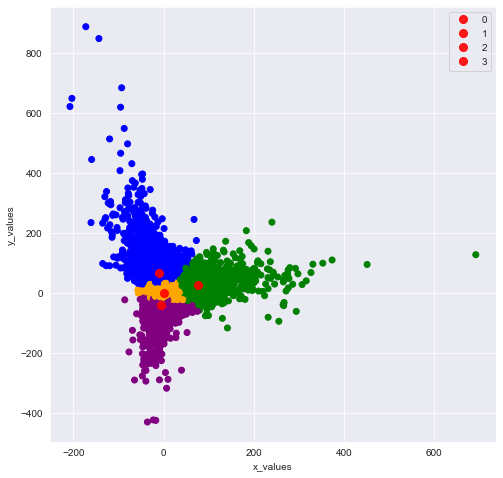

In [63]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

Have found a possible clustering for the customers. Let's see if we also manage to find some interesting pattern beneath it.

In [64]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,5,0
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,2,0,19,0


In [65]:
print (clust_prod.shape)

(206209, 135)


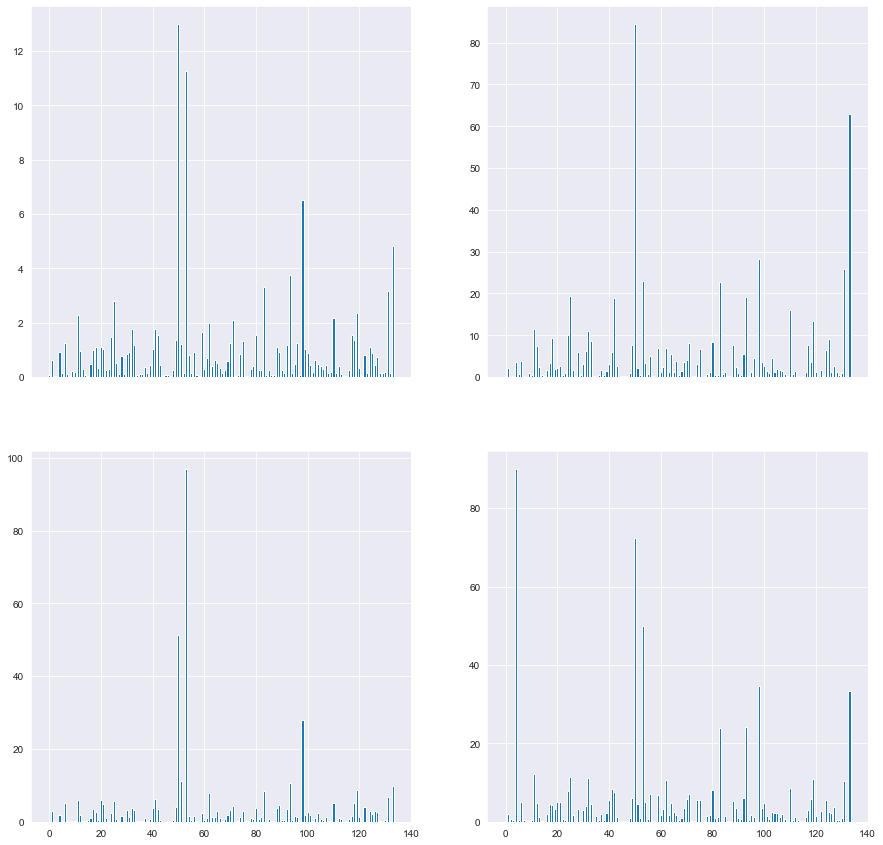

In [66]:
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)

c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)

c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()

Let's check out what are the top 10 goods bought by people of each cluster. We are going to rely first on the absolute data and then on a percentage among the top 8 products for each cluster.

In [67]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                    12.997
fresh vegetables                11.265
packaged vegetables fruits       6.532
yogurt                           4.839
packaged cheese                  3.755
milk                             3.303
water seltzer sparkling water    3.169
chips pretzels                   2.783
soy lactosefree                  2.350
bread                            2.279
dtype: float64

In [68]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                    84.445
yogurt                          62.985
packaged vegetables fruits      28.129
water seltzer sparkling water   25.796
fresh vegetables                22.892
milk                            22.727
chips pretzels                  19.450
packaged cheese                 19.043
energy granola bars             19.022
refrigerated                    16.013
dtype: float64

In [69]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh vegetables                96.942
fresh fruits                    51.420
packaged vegetables fruits      27.925
fresh herbs                     11.318
packaged cheese                 10.646
yogurt                           9.926
soy lactosefree                  8.805
milk                             8.353
frozen produce                   7.815
water seltzer sparkling water    6.770
dtype: float64

In [70]:
c3.sort_values(ascending=False)[0:10]

aisle
baby food formula            90.031
fresh fruits                 72.334
fresh vegetables             50.059
packaged vegetables fruits   34.557
yogurt                       33.243
packaged cheese              24.305
milk                         23.997
bread                        12.201
chips pretzels               11.458
crackers                     11.248
dtype: float64

First analysis of the clusters confirm the initial hypothesis that:
- fresh fruits
- fresh vegetables
- packaged vegetables fruits
- yogurt
- packaged cheese
- milk
- water seltzer sparkling water
- chips pretzels
are products which are genereically bought by the majority of the customers.

What we can inspect here is if clusters differ in quantities and proportions, with respect of these goods, or if a cluster is characterized by some goods not included in this list. For instance we can already see cluster 3 is characterized by 'Baby Food Formula' product which is a significant difference with respect to the other clusters.

In [74]:
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
cluster_means

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,12.997,11.265,6.532,4.839,3.755,3.303,3.169,2.783
1,84.445,22.892,28.129,62.985,19.043,22.727,25.796,19.450
2,51.420,96.942,27.925,9.926,10.646,8.353,6.770,5.796
3,72.334,50.059,34.557,33.243,24.305,23.997,10.528,11.458


The following table depicts the percentage these goods with respect to the other top 8 in each cluster. It is easy some interesting differences among the clusters.

It seems people of cluster 1 buy more fresh vegetables than the other clusters. As shown by absolute data, Cluster 1 is also the cluster including those customers buying far more goods than any others.

People of cluster 2 buy more yogurt than people of the other clusters.

Absolute Data shows us People of cluster 3 buy a Lot of 'Baby Food Formula' which not even listed in the top 8 products but mainly characterize this cluster. Coherently with this observation they buy more milk than the others.

In [76]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
cluster_perc

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,26.720,23.158,13.429,9.948,7.719,6.791,6.514,5.721
1,29.582,8.019,9.854,22.064,6.671,7.961,9.036,6.813
2,23.611,44.514,12.823,4.558,4.888,3.836,3.109,2.661
3,27.769,19.218,13.267,12.762,9.331,9.212,4.042,4.399


An interesting insight by looking at the 10th to 15th most bought products for each cluster which will not include the generic products (i.e. vegetables, fruits, water, etc.) bought by anyone.

In [77]:
c0.sort_values(ascending=False)[10:15]

aisle
refrigerated     2.169
ice cream ice    2.083
frozen produce   2.001
eggs             1.778
crackers         1.766
dtype: float64

In [78]:
c1.sort_values(ascending=False)[10:15]

aisle
soy lactosefree   13.437
bread             11.515
crackers          10.998
cereal             9.971
candy chocolate    9.348
dtype: float64

In [79]:
c2.sort_values(ascending=False)[10:15]

aisle
eggs                       6.177
canned jarred vegetables   6.100
bread                      6.015
chips pretzels             5.796
refrigerated               5.281
dtype: float64

In [80]:
c3.sort_values(ascending=False)[10:15]

aisle
soy lactosefree                 11.003
frozen produce                  10.577
water seltzer sparkling water   10.528
refrigerated                     8.530
eggs                             8.318
dtype: float64